In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import scipy.stats as sps
import progressbar

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp


def modemod(x):
    mo = sps.mode(x)
    return mo.mode[0]

In [4]:
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
def plotPhaseSpace(fofID, centralID):
    
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    # find all the particleIDs that once belong to the subgroup
#     Idlist, vallist, valcen = [], [], []
    #Idlist, vallist = [], []
    Idlist = []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            
            
#             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

#             posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

#             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

#             rr = np.sqrt(xx**2+yy**2+zz**2)

#             ik = np.where(rr<rop)[0]
            
#             tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))
            
            # calcule the value for color coding the graph
            #val = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            #IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
            #Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
            #ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
            #val = tempFromMass(Mass, Abund, IE, ne1)
            #val = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
            #return None
            # if val is one for each particles just append, otherwise do the next
            #vallist.extend([val]*tempIds.size)
            # or
            #vallist.extend(list(val))

    #Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist = np.array(Idlist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    #vallist = vallist[Idunique]
    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
    TdayCoord = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]

    posPart = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]

    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    rr = np.sqrt(xx**2+yy**2+zz**2)

    ik = np.where(rr<rop)[0]

    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]
    
    
    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    
    #print(IndexT_[0], IndexT_[int(IndexT_.size/2)], IndexT_[-1])
    
    LostCoord = sim['SnapNumber_128/PartType4/Coordinates'][IndexT_]
    
    
#     # ... and the redshift
#     SurvIds_ = TdayTotalIDs[IndexT_]
#     iidex = np.in1d(Idlist, SurvIds_)
#     iidex_ = np.where(iidex)[0]
#     vallist_, Idlist_ = vallist[iidex_], Idlist[iidex_]

#     is1 = np.argsort(SurvIds_) # the target
#     is2 = np.argsort(Idlist_)

#     valorder = np.zeros(IndexT_.size)
#     valorder[is1] = vallist_[is2]
    
    #now lets cut at  a certain distance
    distance = 600 # distance in ckpc

    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut]
    
    #valorder_near = valorder[icut]
    #IndexT_near = IndexT_
    #valorder_near = valorder
    
    NearCoord = sim['SnapNumber_128/PartType4/Coordinates'][IndexT_near]
    NearVel = sim['SnapNumber_128/PartType4/Velocities'][IndexT_near]
    
    #and the current status
    Status = np.zeros(IndexT_near.size)
    
    Thegroup = sim['SnapNumber_128/SubGroups/GroupNumber'][fofID]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]
    
    PartGroup = sim['SnapNumber_128/PartType4/GroupNumber'][IndexT_near]
    PartSubGroup = sim['SnapNumber_128/PartType4/SubGroupNumber'][IndexT_near]
    
    free = np.where((PartGroup == -1) & (PartSubGroup ==-1))
    ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
    centralGal = np.where(PartSubGroup == 0)
    otherGal = np.where((PartGroup == Thegroup) & (PartSubGroup > 0))
    otherGroup = np.where((PartGroup != Thegroup) & (PartGroup != -1))
    
    Status[free] = 0
    Status[ICM] = 1
    Status[centralGal] = 2
    Status[otherGal] = 3
    Status[otherGroup] = 4
    
    
    # here i make the cut.
    return NearCoord, NearVel, Status

In [6]:
#  4338, 4341 (4337), 4470 y 4474 (4469)
NearCoord, NearVel, valorder_near = plotPhaseSpace(4341,4337)

73


([<matplotlib.axis.XTick at 0x7f1db0d42e48>,
 [Text(0, 0, 'free'),
  Text(0, 0, 'ICM'),
  Text(0, 0, 'central'),
  Text(0, 0, 'other galaxy'),
  Text(0, 0, 'other group')])

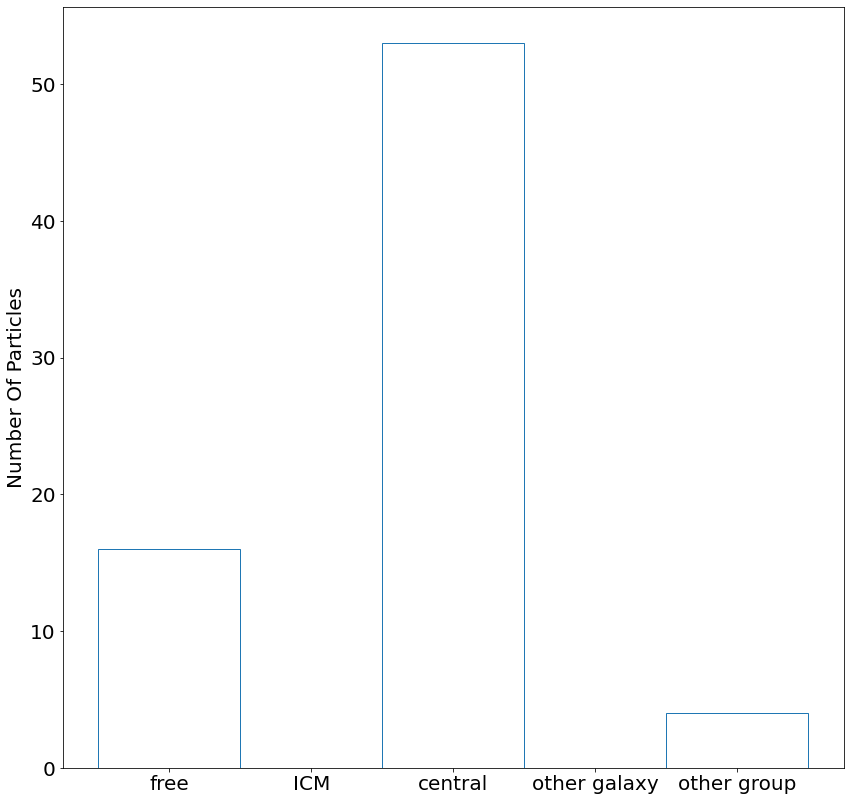

In [7]:
print(valorder_near.size)
pl.figure(figsize=(14, 14))

bins = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
pl.hist(valorder_near, bins=bins, histtype='step')

pl.ylabel('Number Of Particles')
pl.xticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))

(73, 3)


[Text(1, 0, 'free'),
 Text(1, 0, 'ICM'),
 Text(1, 0, 'central'),
 Text(1, 0, 'other galaxy'),
 Text(1, 0, 'other group')]

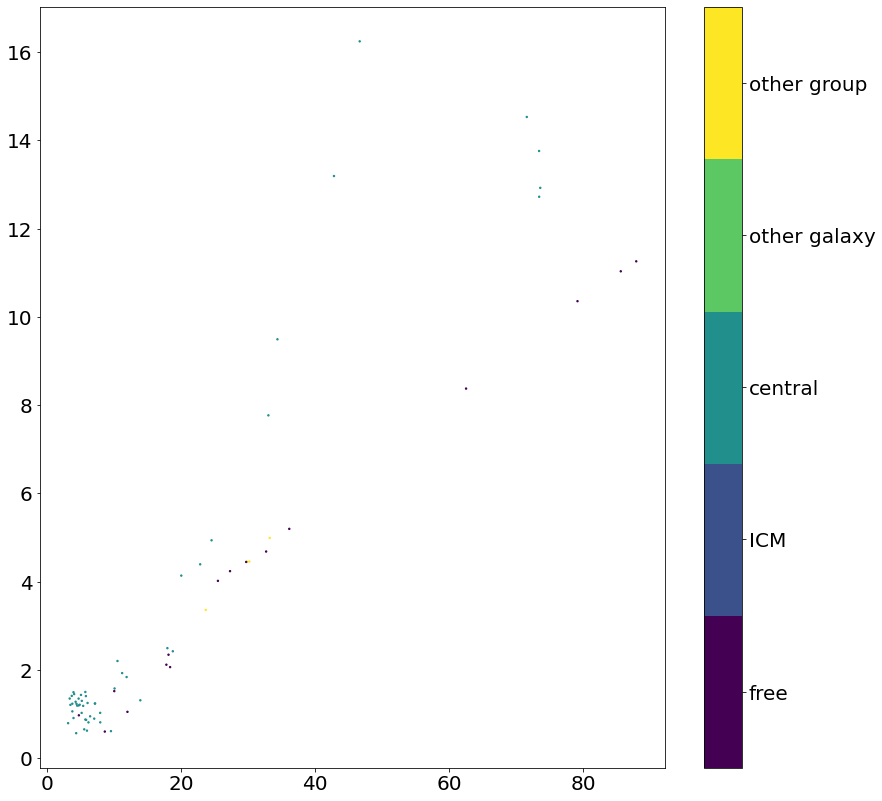

In [8]:
print(NearCoord.shape)

cen = sim['SnapNumber_128/SubGroups/SubGroupPos'][4341]
cenvel =  sim['SnapNumber_128/SubGroups/SubGroupVel'][4341]

rad = sim['SnapNumber_128/SubGroups/OpticalRadius'][4341]
veldisp = sim['SnapNumber_128/SubGroups/SubGroupVelDisp'][4341]


x, y, z = NearCoord[:,0] - cen[0], NearCoord[:,1] - cen[1], NearCoord[:,2] - cen[2]
xv, yv, zv = NearVel[:,0]-cenvel[0], NearVel[:,1]-cenvel[1], NearVel[:,2]-cenvel[2]

r = np.sqrt(x**2+y**2+z**2)
v = np.sqrt(xv**2+yv**2+zv**2)

rr = r/rad
vv = v/veldisp

papels = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])

pl.figure(figsize=(14,14))

norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(rr, vv, c=valorder_near, s=2, norm=norm)

bar=pl.colorbar()
bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

In [9]:
# ok, make a list of all satellites of 4337
groups = sim['SnapNumber_128/SubGroups/GroupNumber'][()]
group = groups[4337]

sat = np.where(groups==group)[0][1:]
print(sat)

[4338 4339 4340 4341 4342 4343 4344 4345 4346 4347 4348 4349 4350 4351
 4352 4353 4354 4355 4356 4357 4358 4359 4360 4361 4362 4363 4364 4365
 4366 4367 4368 4369 4370 4371 4372 4373 4374 4375 4376 4377 4378 4379
 4380 4381 4382 4383 4384 4385 4386 4387 4388 4389 4390 4391 4392 4393
 4394 4395 4396 4397 4398 4399 4400 4401 4402 4403 4404 4405 4406 4407
 4408 4409 4410 4411 4412 4413 4414 4415 4416 4417 4418 4419 4420 4421
 4422 4423 4424 4425 4426 4427 4428 4429 4430 4431 4432 4433 4434 4435
 4436 4437 4438 4439 4440 4441 4442 4443 4444 4445 4446 4447 4448 4449
 4450 4451 4452 4453 4454 4455 4456 4457 4458 4459 4460 4461 4462 4463
 4464 4465 4466 4467 4468]


In [10]:
X, Y, Z = [], [], []
VX,VY, VZ = [], [], []
Temp = []

pbar = progressbar.ProgressBar(max_value=sat.size)

for i, ss in enumerate(sat):
    NearCoord, NearVel, valorder_near = plotPhaseSpace(ss,4337)
    X.extend(list(NearCoord[:,0]))
    Y.extend(list(NearCoord[:,1]))
    Z.extend(list(NearCoord[:,2]))
    
    VX.extend(list(NearVel[:,0]))
    VY.extend(list(NearVel[:,1]))
    VZ.extend(list(NearVel[:,2]))
    
    Temp.extend(list(valorder_near))
    pbar.update(i)
    
X, Y, Z  = np.array(X), np.array(Y), np.array(Z)
VX,VY, VZ = np.array(VX), np.array(VY), np.array(VZ)

Temp = np.array(Temp)

 99% (130 of 131) |##################### | Elapsed Time: 0:02:11 ETA:   0:00:00

In [11]:
# and of all satellites of 4469
group2 = groups[4469]

sat2 = np.where(groups==group2)[0][1:]
print(sat2)

[4470 4471 4472 4473 4474 4475 4476 4477 4478 4479 4480 4481 4482 4483
 4484 4485 4486 4487 4488 4489 4490 4491 4492 4493 4494 4495 4496 4497
 4498 4499 4500 4501 4502 4503 4504 4505 4506 4507 4508 4509 4510 4511
 4512 4513 4514 4515 4516 4517 4518 4519 4520 4521 4522 4523 4524 4525
 4526 4527 4528 4529 4530 4531 4532 4533 4534 4535 4536 4537 4538 4539
 4540 4541 4542 4543 4544 4545 4546 4547 4548 4549 4550 4551 4552 4553
 4554 4555 4556 4557 4558 4559 4560 4561 4562 4563 4564 4565 4566 4567
 4568 4569 4570 4571 4572 4573 4574 4575 4576 4577 4578 4579 4580 4581
 4582 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593 4594 4595
 4596 4597 4598 4599 4600 4601 4602 4603 4604 4605 4606 4607 4608 4609
 4610 4611 4612 4613 4614 4615 4616 4617 4618 4619 4620 4621 4622 4623
 4624 4625 4626 4627]


In [12]:
def ploty(cen, sa):
    gro = groups[cen]
    cenG = sim['SnapNumber_128/Groups/GroupCM'][gro]
    cenBCG = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
    cenGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][sa]
    
    print(cenBCG[0]-cenG[0], cenBCG[1]-cenG[1], cenBCG[2]-cenG[2])
    
    fig = ipv.figure(width=750, height=750)
    
    snap = ipv.scatter(np.array([cenG[0]-cenG[0]]), np.array([cenG[1]-cenG[1]]), np.array([cenG[2]-cenG[2]]), color='black', marker='sphere')
    snap2 = ipv.scatter(np.array([cenBCG[0]-cenG[0]]), np.array([cenBCG[1]-cenG[1]]), np.array([cenBCG[2]-cenG[2]]), color='red', marker='sphere')
    snap3 = ipv.scatter(cenGal[:,0]-cenG[0], cenGal[:,1]-cenG[1], cenGal[:,2]-cenG[2], color='green', marker='sphere')
    
    ipv.show()

In [13]:
ploty(4337, sat)

0.01953125 0.00390625 -0.015625


In [14]:
ploty(4469, sat2)

0.0234375 -0.01953125 -0.00390625


In [15]:
X, Y, Z = [], [], []
VX,VY, VZ = [], [], []
Temp = []

pbar = progressbar.ProgressBar(max_value=sat.size)

for i, ss in enumerate(sat):
    NearCoord, NearVel, valorder_near = plotPhaseSpace(ss,4337)
    X.extend(list(NearCoord[:,0]))
    Y.extend(list(NearCoord[:,1]))
    Z.extend(list(NearCoord[:,2]))
    
    VX.extend(list(NearVel[:,0]))
    VY.extend(list(NearVel[:,1]))
    VZ.extend(list(NearVel[:,2]))
    
    Temp.extend(list(valorder_near))
    pbar.update(i)
    
X, Y, Z  = np.array(X), np.array(Y), np.array(Z)
VX,VY, VZ = np.array(VX), np.array(VY), np.array(VZ)

Temp = np.array(Temp)

 99% (130 of 131) |##################### | Elapsed Time: 0:02:06 ETA:   0:00:00

In [16]:
cenT = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]
velT = sim['SnapNumber_128/SubGroups/SubGroupVel'][4337]

Xn, Yn, Zn = X-cenT[0], Y-cenT[1], Z-cenT[2]
VXn ,VYn, VZn = VX-velT[0] ,VY-velT[1] , VZ-velT[2]

Text(0, 0.5, 'velocity/(km/s)')

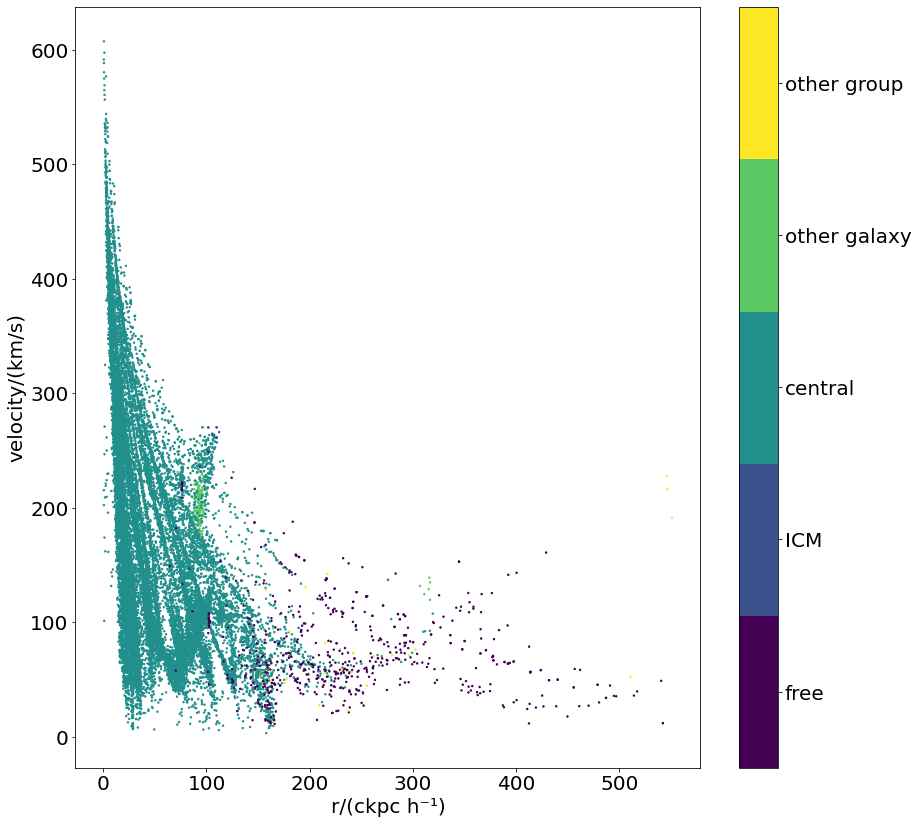

In [17]:
RR = np.sqrt(Xn**2+Yn**2+Zn**2)
VV = np.sqrt(VXn**2+VYn**2+VZn**2)

pl.figure(figsize=(14,14))

papels = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(RR, VV, c=Temp, s=2, norm=norm)

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')


bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/(ckpc h⁻¹)')
pl.ylabel('velocity/(km/s)')

In [18]:
G = 4.3009*1e-6 # in kpc (km/s)^2 M_sun^-1
M200 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

M200 = M200*1e10
vdisp = np.sqrt(G*M200/R200)
#vYang = 397.9 * (M200/1e14)**(0.3214)

Text(0, 0.5, 'velocity/sigma')

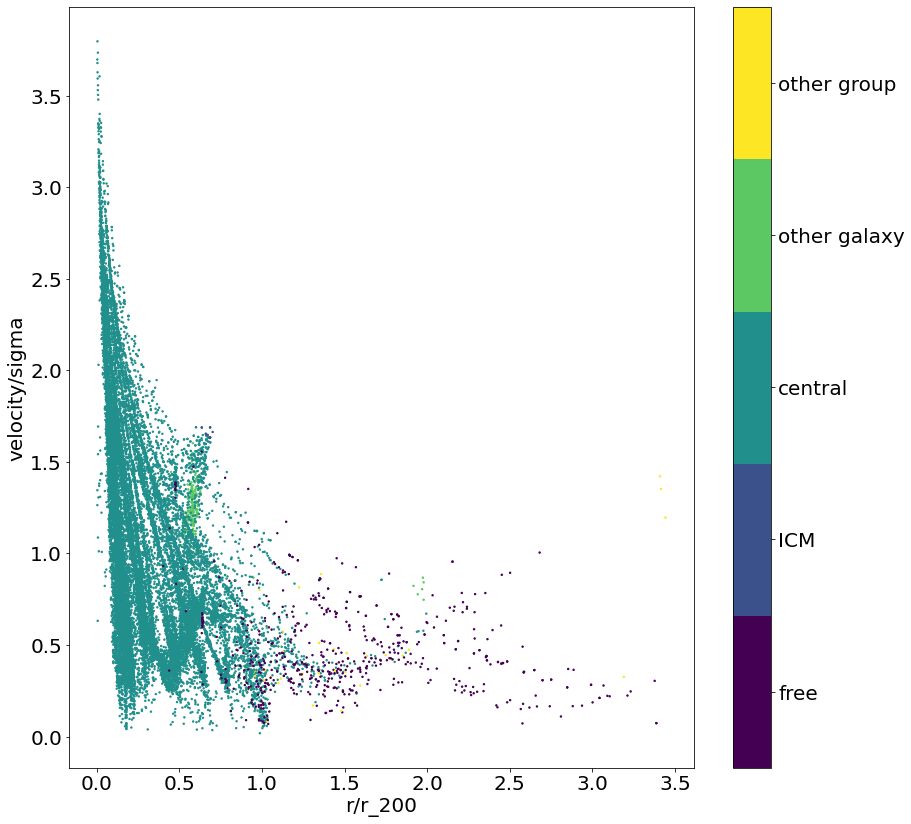

In [19]:
RR200 = RR/R200
VV200 = VV/vdisp

pl.figure(figsize=(14,14))

pl.scatter(RR200, VV200, c=Temp, s=2, norm=norm)

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')


bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/r_200')
pl.ylabel('velocity/sigma')

Text(0, 0.5, 'velocity/sigma')

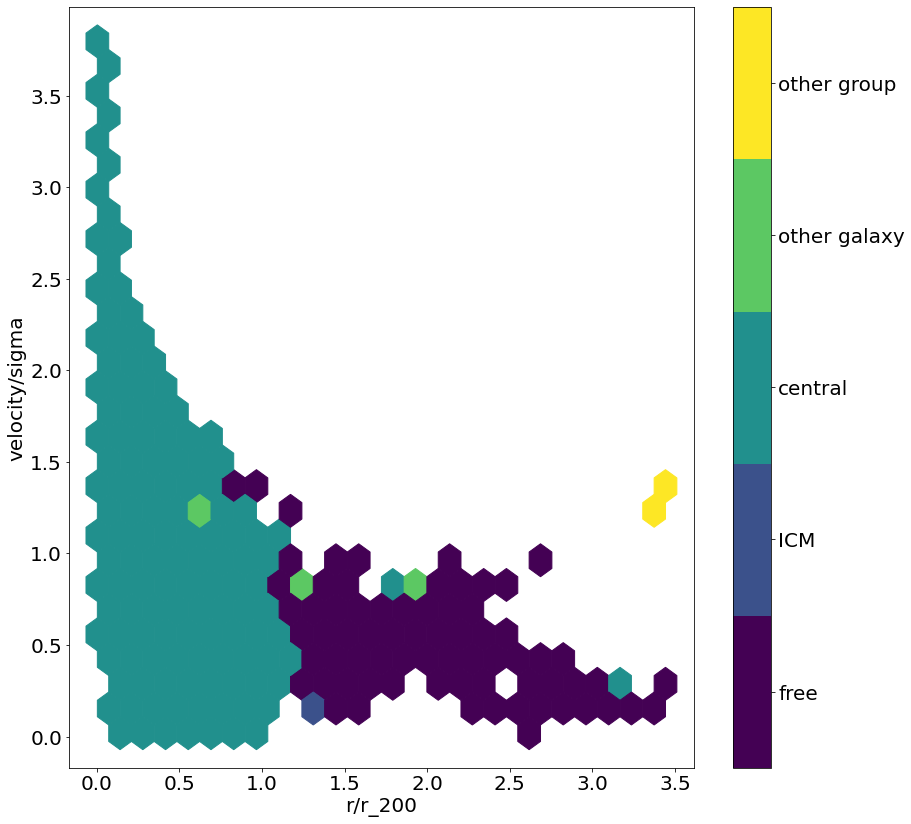

In [20]:
pl.figure(figsize=(14,14))

pl.hexbin(RR200, VV200, C=Temp, gridsize=25, norm=norm, reduce_C_function=np.median)

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/r_200')
pl.ylabel('velocity/sigma')

In [21]:
# and now the other group

In [22]:
X2, Y2, Z2 = [], [], []
VX2,VY2, VZ2 = [], [], []
Temp2 = []

pbar2 = progressbar.ProgressBar(max_value=sat2.size)

for i, ss in enumerate(sat2):
    NearCoord2, NearVel2, valorder_near2 = plotPhaseSpace(ss,4469)
    X2.extend(list(NearCoord2[:,0]))
    Y2.extend(list(NearCoord2[:,1]))
    Z2.extend(list(NearCoord2[:,2]))
    
    VX2.extend(list(NearVel2[:,0]))
    VY2.extend(list(NearVel2[:,1]))
    VZ2.extend(list(NearVel2[:,2]))
    
    Temp2.extend(list(valorder_near2))
    pbar2.update(i)
    
X2, Y2, Z2  = np.array(X2), np.array(Y2), np.array(Z2)
VX2, VY2, VZ2 = np.array(VX2), np.array(VY2), np.array(VZ2)

Temp2 = np.array(Temp2)

 99% (157 of 158) |##################### | Elapsed Time: 0:00:54 ETA:   0:00:00

In [23]:
group, group2

(4671, 4672)

In [24]:
cenT2 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4469]
velT2 = sim['SnapNumber_128/SubGroups/SubGroupVel'][4469]

Xn2, Yn2, Zn2 = X2-cenT2[0], Y2-cenT2[1], Z2-cenT2[2]
VXn2 ,VYn2, VZn2 = VX2-velT2[0] ,VY2-velT2[1] , VZ2-velT2[2]

Text(0, 0.5, 'velocity/(km/s)')

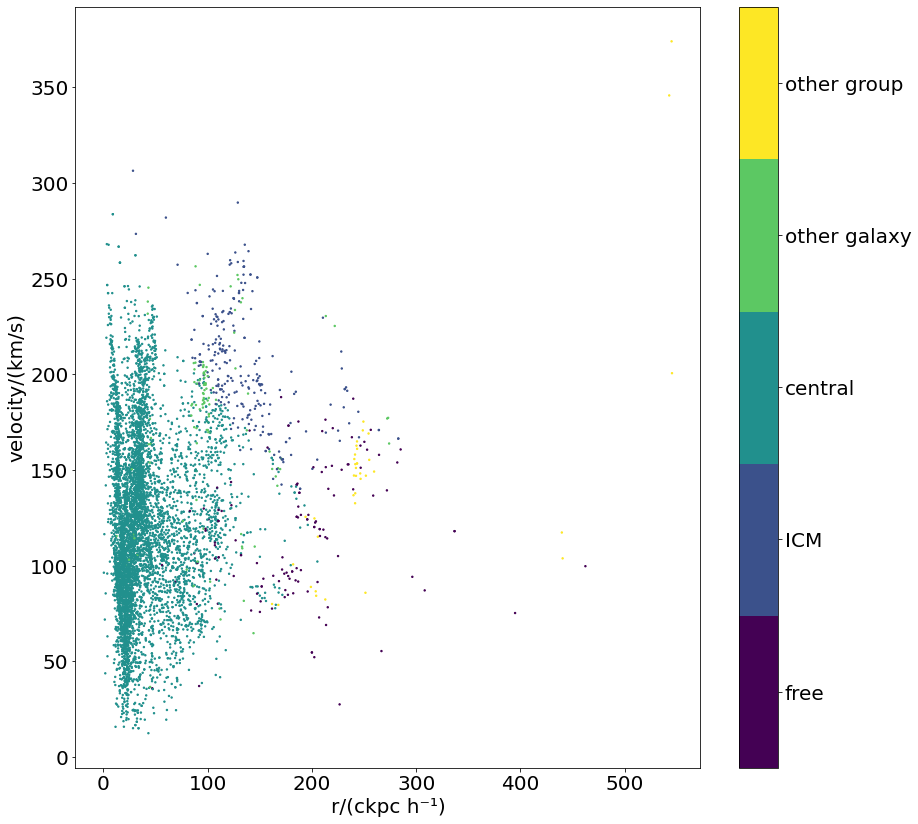

In [25]:
RR2 = np.sqrt(Xn2**2+Yn2**2+Zn2**2)
VV2 = np.sqrt(VXn2**2+VYn2**2+VZn2**2)

pl.figure(figsize=(14,14))

papels2 = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(RR2, VV2, c=Temp2, s=2, norm=norm2)

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/(ckpc h⁻¹)')
pl.ylabel('velocity/(km/s)')

In [26]:
G = 4.3009*1e-6 # in kpc (km/s)^2 M_sun^-1
M200_2 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group2]
R200_2 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group2]

M200_2 = M200_2*1e10
vdisp2 = np.sqrt(G*M200_2/R200_2)
#vYang = 397.9 * (M200/1e14)**(0.3214)

In [27]:
vdisp2

137.027039706534

Text(0, 0.5, 'velocity/sigma')

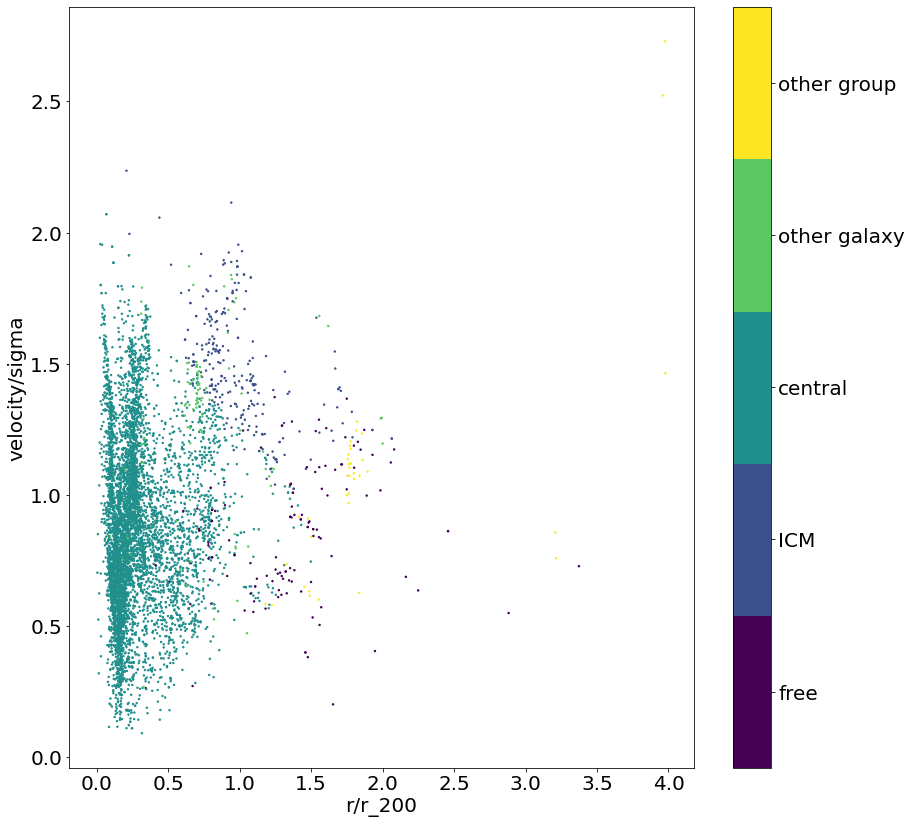

In [28]:
RR200_2 = RR2/R200_2
VV200_2 = VV2/vdisp2

pl.figure(figsize=(14,14))

pl.scatter(RR200_2, VV200_2, c=Temp2, s=2, norm=norm2)

bar = pl.colorbar()
bar.set_ticks(papels2)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/r_200')
pl.ylabel('velocity/sigma')

Text(0, 0.5, 'velocity/sigma')

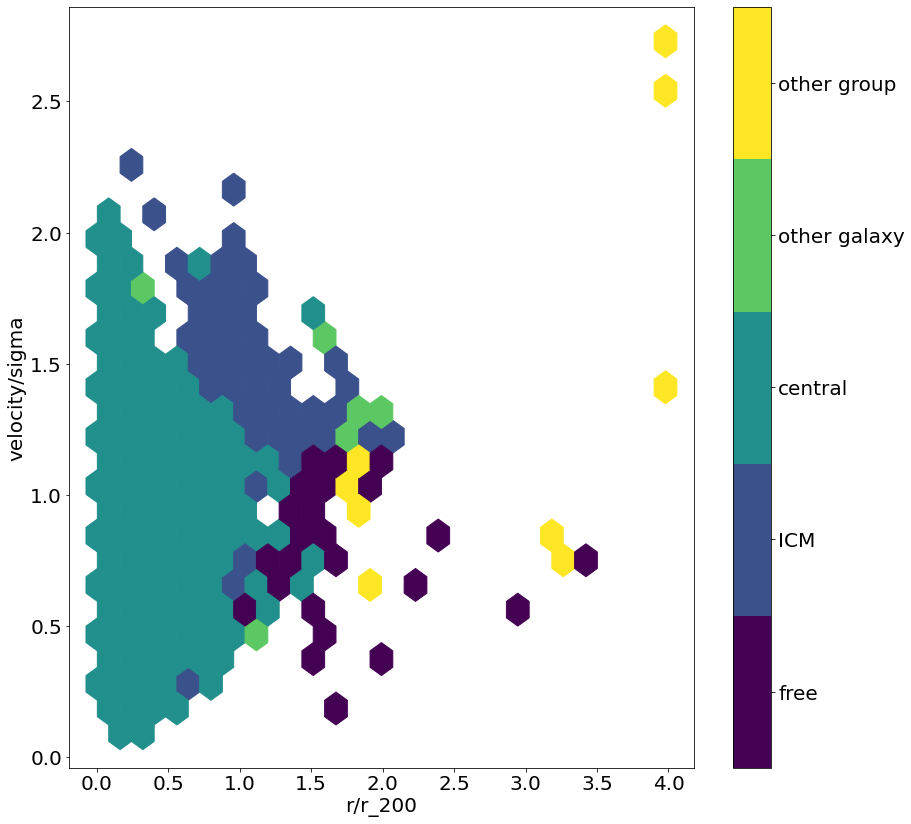

In [29]:
pl.figure(figsize=(14,14))

pl.hexbin(RR200_2, VV200_2, C=Temp2, gridsize=25, norm=norm2, reduce_C_function=np.median)

bar = pl.colorbar()
bar.set_ticks(papels2)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('r/r_200')
pl.ylabel('velocity/sigma')

In [30]:
cenT = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]
velT = sim['SnapNumber_128/SubGroups/SubGroupVel'][4337]

group, group2 = 4671, 4672

In [31]:
offG1 = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
offDM1 = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
offSt = sim['SnapNumber_128/Groups/PartType4/Offsets'][group].astype('int')

In [32]:
gp = sim['SnapNumber_128/PartType0/Coordinates'][offG1[0]:offG1[1]]
gv = sim['SnapNumber_128/PartType0/Velocities'][offG1[0]:offG1[1]]

dmp = sim['SnapNumber_128/PartType1/Coordinates'][offDM1[0]:offDM1[1]]
dmv = sim['SnapNumber_128/PartType1/Velocities'][offDM1[0]:offDM1[1]]

stp = sim['SnapNumber_128/PartType4/Coordinates'][offSt[0]:offSt[1]]
stv = sim['SnapNumber_128/PartType4/Velocities'][offSt[0]:offSt[1]]

In [33]:
G = 4.3009*1e-6 # in kpc (km/s)^2 M_sun^-1
M200 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
R200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]

M200 = M200*1e10
vdisp = np.sqrt(G*M200/R200)

In [34]:
xdm, ydm, zdm = dmp[:,0] - cenT[0], dmp[:,1] - cenT[1], dmp[:,2] - cenT[2]
vxdm, vydm, vzdm = dmv[:,0] - velT[0],  dmv[:,1] - velT[1], dmv[:,2] - velT[2]

r = np.sqrt(xdm**2+ydm**2+zdm**2)
v = np.sqrt(vxdm**2+vydm**2+vzdm**2)

rr = r/R200
vv = v/vdisp

Text(0, 0.5, 'velocities/sigma')

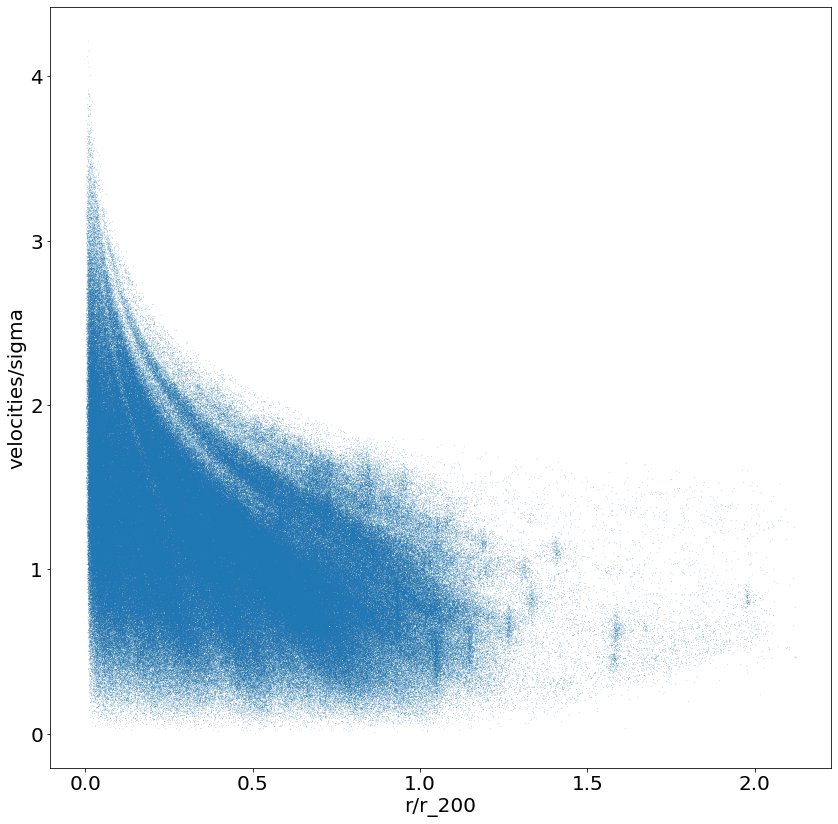

In [35]:
pl.figure(figsize=(14, 14))

pl.scatter(rr, vv, s=0.005)

pl.xlabel('r/r_200')
pl.ylabel('velocities/sigma')

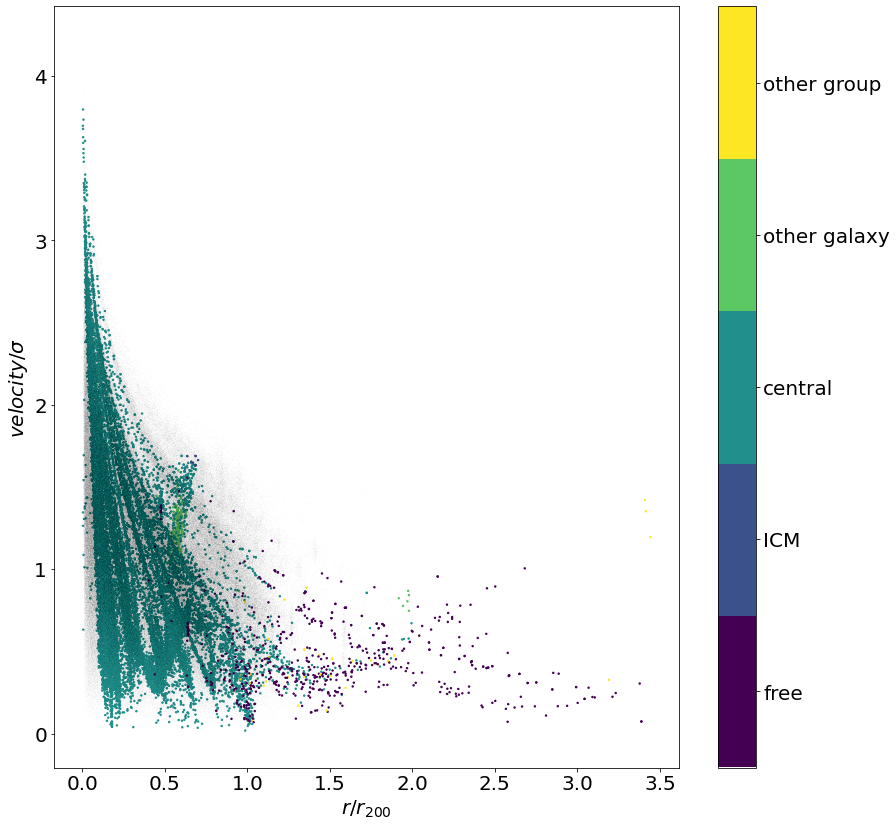

In [36]:
pl.figure(figsize=(14,14))

pl.scatter(RR200, VV200, c=Temp, s=2, norm=norm)
# pl.scatter(rr, vv, s=0.0001, color='black')
pl.plot(rr, vv, color='black', marker=',', alpha=.01, ls='')

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('$r/r_{200}$')
pl.ylabel('$velocity/\sigma$')


pl.savefig('paperGraphs/phase_space_Group_4671.pdf')

Text(0, 0.5, '$velocity/\\sigma$')

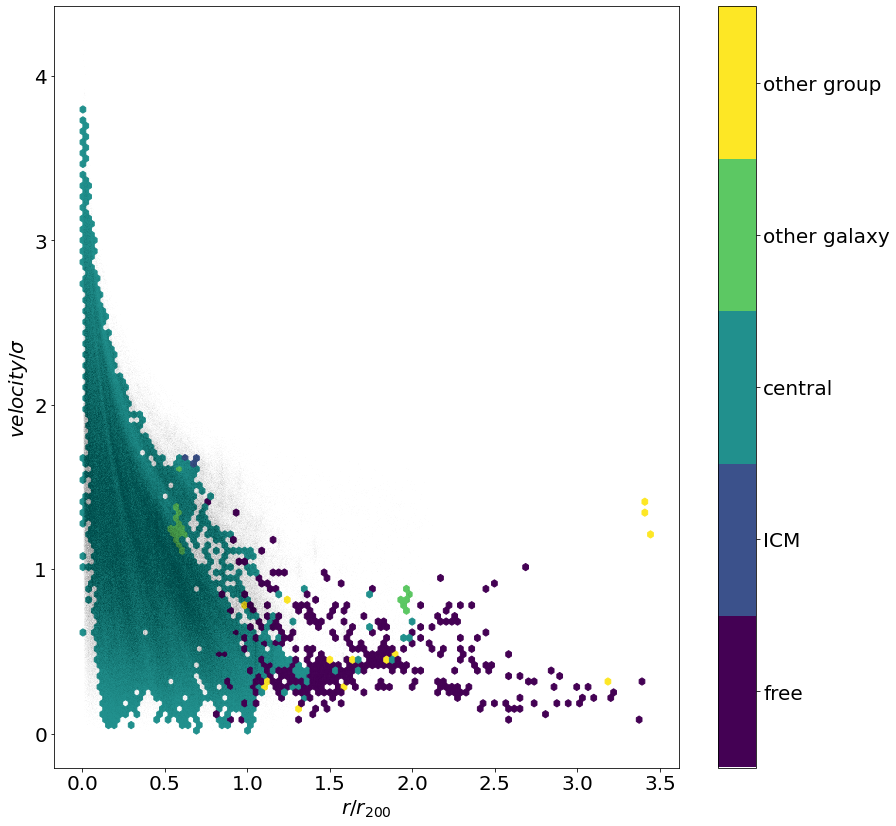

In [37]:
pl.figure(figsize=(14,14))

# pl.scatter(RR200, VV200, c=Temp, s=2, norm=norm)
pl.hexbin(RR200, VV200, C=Temp, gridsize=100, norm=norm, reduce_C_function=modemod)
# pl.scatter(rr, vv, s=0.0001, color='black')
pl.plot(rr, vv, color='black', marker=',', alpha=.01, ls='')

bar = pl.colorbar()
bar.set_ticks(papels)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('$r/r_{200}$')
pl.ylabel('$velocity/\sigma$')

# pl.savefig('paperGraphs/phase_space_Group_4671_binned.pdf')

In [38]:
cenT2 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4469]
velT2 = sim['SnapNumber_128/SubGroups/SubGroupVel'][4469]

In [39]:
offG2 = sim['SnapNumber_128/Groups/PartType0/Offsets'][group2].astype('int')
offDM2 = sim['SnapNumber_128/Groups/PartType1/Offsets'][group2].astype('int')
offSt2 = sim['SnapNumber_128/Groups/PartType4/Offsets'][group2].astype('int')

In [40]:
gp2 = sim['SnapNumber_128/PartType0/Coordinates'][offG2[0]:offG2[1]]
gv2 = sim['SnapNumber_128/PartType0/Velocities'][offG2[0]:offG2[1]]

dmp2 = sim['SnapNumber_128/PartType1/Coordinates'][offDM2[0]:offDM2[1]]
dmv2 = sim['SnapNumber_128/PartType1/Velocities'][offDM2[0]:offDM2[1]]

stp2 = sim['SnapNumber_128/PartType4/Coordinates'][offSt2[0]:offSt2[1]]
stv2 = sim['SnapNumber_128/PartType4/Velocities'][offSt2[0]:offSt2[1]]

In [41]:
M200_2 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group2]
R200_2 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group2]

M200_2 = M200_2*1e10
vdisp2 = np.sqrt(G*M200_2/R200_2)

In [42]:
xdm2, ydm2, zdm2 = dmp2[:,0] - cenT2[0], dmp2[:,1] - cenT2[1], dmp2[:,2] - cenT2[2]
vxdm2, vydm2, vzdm2 = dmv2[:,0] - velT2[0],  dmv2[:,1] - velT2[1], dmv2[:,2] - velT2[2]

r2 = np.sqrt(xdm2**2+ydm2**2+zdm2**2)
v2 = np.sqrt(vxdm2**2+vydm2**2+vzdm2**2)

rr2 = r2/R200_2
vv2 = v2/vdisp2

Text(0, 0.5, 'velocities/sigma')

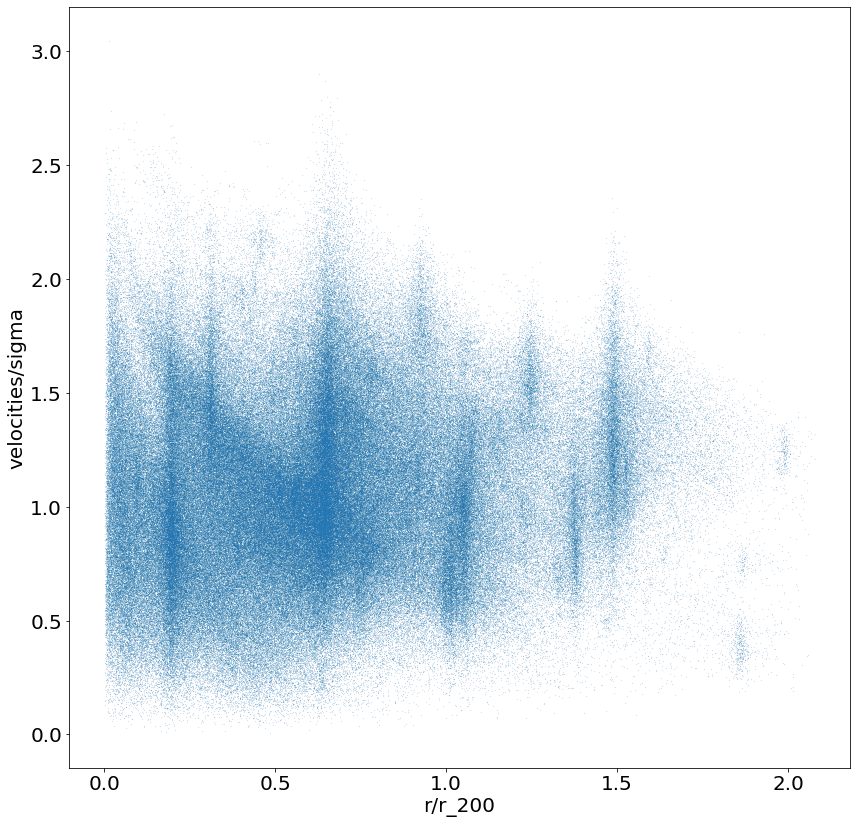

In [43]:
pl.figure(figsize=(14, 14))

pl.scatter(rr2, vv2, s=0.005)

pl.xlabel('r/r_200')
pl.ylabel('velocities/sigma')

Text(0, 0.5, '$velocity/\\sigma$')

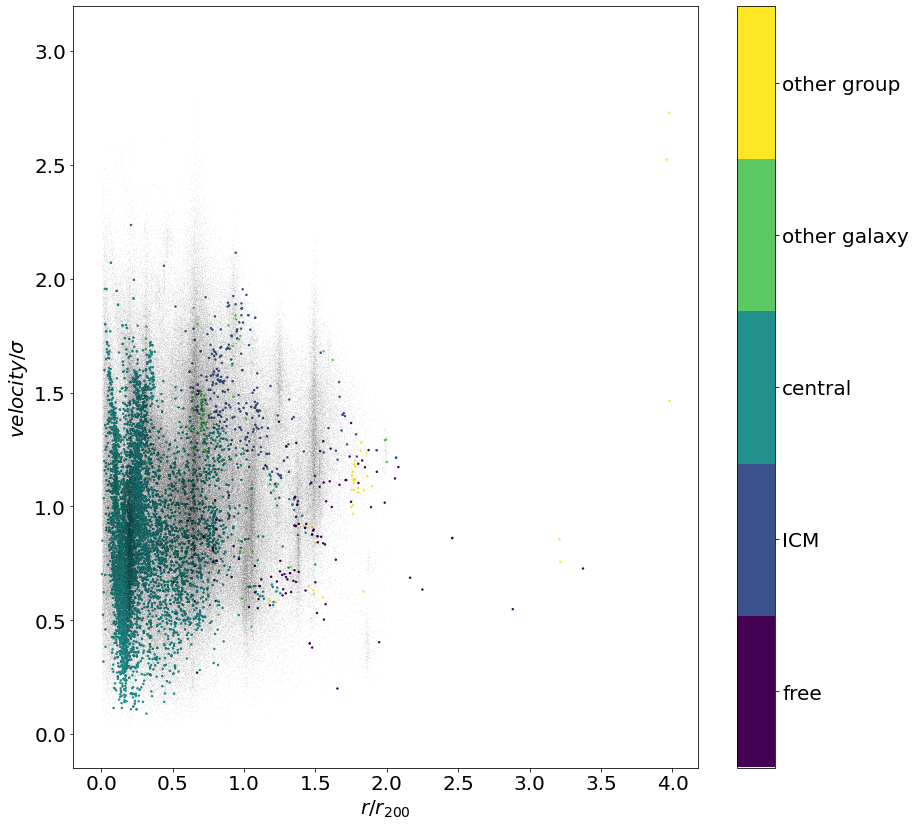

In [44]:
pl.figure(figsize=(14,14))

pl.scatter(RR200_2, VV200_2, c=Temp2, s=2, norm=norm2)
#pl.scatter(rr2, vv2, s=0.0001, color='black')
pl.plot(rr2, vv2, color='black', marker=',', alpha=.03, ls='')

bar = pl.colorbar()
bar.set_ticks(papels2)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('$r/r_{200}$')
pl.ylabel('$velocity/\sigma$')

# pl.savefig('paperGraphs/phase_space_Group_4672.pdf')

Text(0, 0.5, '$velocity/\\sigma$')

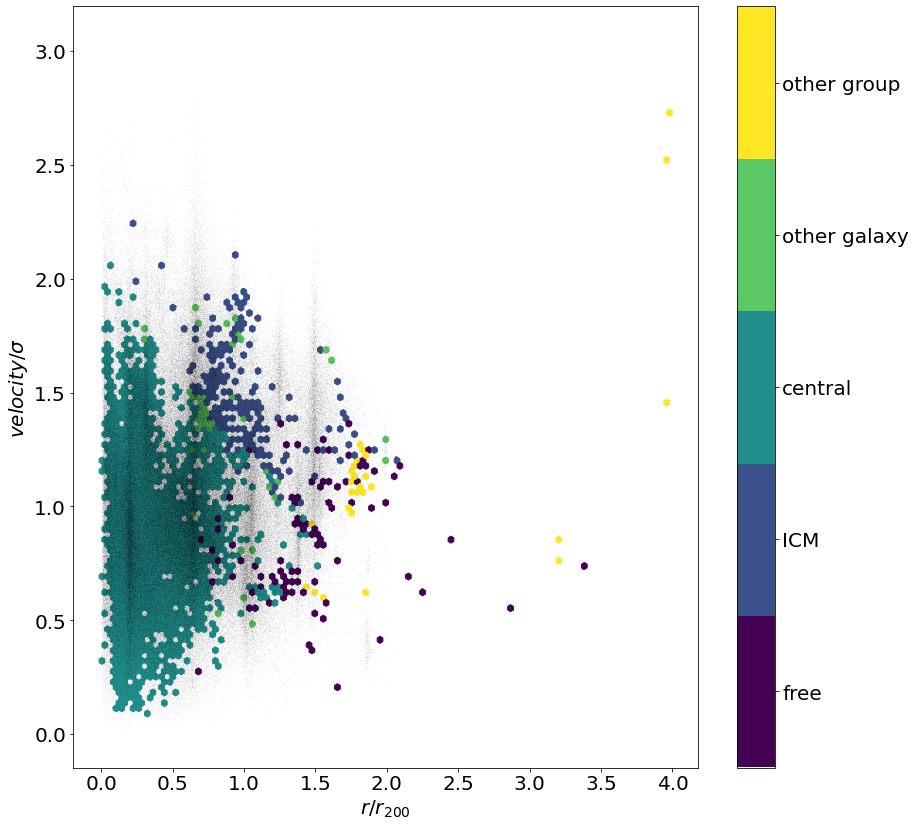

In [45]:
pl.figure(figsize=(14,14))

pl.scatter(RR200_2, VV200_2, c=Temp2, s=2, norm=norm2)
pl.hexbin(RR200_2, VV200_2, C=Temp2, gridsize=100, norm=norm2, reduce_C_function=modemod)
#pl.scatter(rr2, vv2, s=0.0001, color='black')
pl.plot(rr2, vv2, color='black', marker=',', alpha=.03, ls='')

bar = pl.colorbar()
bar.set_ticks(papels2)
#bar.set_label('Temperature/K')
#bar.set_label('Binding Energy/(km²/s²)')

bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

pl.xlabel('$r/r_{200}$')
pl.ylabel('$velocity/\sigma$')

# pl.savefig('paperGraphs/phase_space_Group_4672_binned.pdf')

In [46]:
sim['SnapNumber_128/PartType4/'].keys()

<KeysViewHDF5 ['Abundances', 'BindingEnergy', 'Circularity', 'Coordinates', 'GroupNumber', 'Masses', 'ParticleIDs', 'Potential', 'SpecificAngularMomentum', 'StellarFormationTime', 'SubFindNumber', 'SubGroupNumber', 'Velocities']>

In [47]:
sim['SnapNumber_128/PartType4/BindingEnergy'].attrs.keys()

<KeysViewHDF5 ['cgs_conversion_factor', 'cgs_units', 'description', 'description_units']>

In [48]:
sim['SnapNumber_128/PartType4/BindingEnergy'].attrs['description']

'Particle binding energy'

In [49]:
sim['SnapNumber_128/PartType4/BindingEnergy'].attrs['description_units']

'$km^{2} s^{-2}$'

In [50]:
# # ok, make a list of all clean satellites
# H5 = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')

# centrals = H5['SatelliteCentral'][()]
# sates = H5['SatelliteList']

# groups = sim['SnapNumber_128/SubGroups/GroupNumber'][()]
# group3 = groups[centrals]

In [51]:
# RRs = []
# VVs = []
# Temp3 = []

# pbar3 = progressbar.ProgressBar(max_value=sates.size)
# i = 0

# for ss, cc in zip(sates, centrals):
#     NearCoord3, NearVel3, valorder_near3 = plotPhaseSpace(ss,cc)
    
#     cenT3 = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
#     velT3 = sim['SnapNumber_128/SubGroups/SubGroupVel'][cc]
    
#     x, y, z = NearCoord3[:,0] - cenT3[0], NearCoord3[:,1] - cenT3[1], NearCoord3[:,2] - cenT3[2]
#     xv, yv, zv = NearVel3[:,0] - velT3[0], NearVel3[:,1] - velT3[1], NearVel3[:,2] - velT3[2]
    
#     rr = np.sqrt(x**2+y**2+z**2)
#     vv = np.sqrt(xv**2+yv**2+zv**2)
    
#     gro = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    
#     G = 4.3009*1e-6 # in kpc (km/s)^2 M_sun^-1
#     M200_3 = sim['SnapNumber_128/Groups/Group_M_Crit200'][gro]
#     R200_3 = sim['SnapNumber_128/Groups/Group_R_Crit200'][gro]

#     M200_3 = M200_3*1e10
#     vdisp3 = np.sqrt(G*M200_3/R200_3)
    
#     Rr = rr/R200_3
#     Vv = vv/vdisp3
    
#     RRs.extend(list(Rr))
#     VVs.extend(list(Vv))
    
#     Temp3.extend(list(valorder_near3))
#     i += 1
#     pbar3.update(i)
    
# RRs, VVs = np.array(RRs), np.array(VVs)
# Temp3 = np.array(Temp3)

In [52]:
# pl.figure(figsize=(14,14))

# papels3 = np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
# norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

# pl.scatter(RRs, VVs, c=Temp3, s=2, norm=norm3)

# bar = pl.colorbar()
# bar.set_ticks(papels3)
# #bar.set_label('Temperature/K')
# #bar.set_label('Binding Energy/(km²/s²)')

# bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
# bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

# pl.xlabel('r/r_200')
# pl.ylabel('velocity/sigma')

# pl.xlim((0., 5.))
# pl.ylim((0.,2.5))

In [53]:
# DMr, DMv = [], []

# cu = np.unique(centrals)

# groupS = sim['SnapNumber_128/SubGroups/GroupNumber'][cu]

# pbar4 = progressbar.ProgressBar(max_value=groupS.size)

# k = 0
# for gg, cc in zip(groupS, cu):
#     offDM = sim['SnapNumber_128/Groups/PartType1/Offsets'][gg].astype('int')
    
#     posDM = sim['SnapNumber_128/PartType1/Coordinates'][offDM[0]:offDM[1]]
#     velDM = sim['SnapNumber_128/PartType1/Velocities'][offDM[0]:offDM[1]]
    
#     cenT4 = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
#     velT4 = sim['SnapNumber_128/SubGroups/SubGroupVel'][cc]
    
#     xDM, yDM, zDM = posDM[:,0] - cenT4[0], posDM[:,1] - cenT4[1], posDM[:,2] - cenT4[2]
#     xvDM, yvDM, zvDM = velDM[:,0] - velT4[0], velDM[:,1] - velT4[1], velDM[:,2] - velT4[2]
    
#     rDM = np.sqrt(xDM**2+yDM**2+zDM**2)
#     vDM = np.sqrt(xvDM**2+yvDM**2+zvDM**2)
    
#     M200_4 = sim['SnapNumber_128/Groups/Group_M_Crit200'][gg]
#     R200_4 = sim['SnapNumber_128/Groups/Group_R_Crit200'][gg]

#     M200_4 = M200_4*1e10
#     vdisp4 = np.sqrt(G*M200_4/R200_4)
    
#     r200DM = rDM/R200_4
#     v200DM = vDM/vdisp4
    
#     DMr.extend(list(r200DM))
#     DMv.extend(list(v200DM))
    
# DMr, DMv = np.array(DMr), np.array(DMv)

In [54]:
# pl.figure(figsize=(14,14))

# pl.scatter(DMr, DMv, color='black', s=0.001)

# pl.xlabel('r/r_200')
# pl.ylabel('velocity/sigma')

# pl.xlim((0., 5.))
# pl.ylim((0.,2.5))

In [55]:
# pl.figure(figsize=(14,14))

# pl.scatter(RRs, VVs, c=Temp3, s=2, norm=norm3)
# # pl.scatter(DMr, DMv, color='black', s=0.00005)
# pl.plot(DMr, DMv, color='black', marker=',', alpha=.02, ls='')

# bar = pl.colorbar()
# bar.set_ticks(papels3)

# bar.set_ticks((0, 1, 2, 3, 4), ('free', 'ICM', 'central', 'other galaxy', 'other group'))
# bar.ax.set_yticklabels(('free', 'ICM', 'central', 'other galaxy', 'other group'))

# pl.xlabel('r/r_200')
# pl.ylabel('velocity/sigma')

# pl.xlim((0., 5.))
# pl.ylim((0.,2.5))

In [56]:
# sim['SnapNumber_128/Header/BoxSize'][()]

In [57]:
# sim['SnapNumber_128/Header/MassTable'].attrs['description_units']

In [58]:
# np.log10(0.00010843*1e10)